# Polynomial Regression - Frequentist Approach


<font color=red size=3> **Application Scenario:**</font> 
The Polynomial Regression is suitable for the following scenario.
- Relationship between input (features) and output (target): Nonlinear

The Polynomial Regression can be implemented by:
- The OLS method (notebook 2 & 3)
- The Gradient Descent Approach (notebook 4 & 5)

In this notebook, we perform **polynomial linear regression** using Scikit-Learn's **OLS Linear Regression** model.

Note that the OLS method is suitable for the following scenarios.
- Dataset: not too large and fits into computer's memory
- No. of Features: not too large





## Why do we need Polynomial Regression Model?

If we have **nonlinear relationship** between the input variables (features) and the output variable (target), then we may create new features by adding powers of each feature to fit the nonlinear line. Finally, we train a linear model on this augmented set of features. This technique is called Polynomial Regression. The degree of a Polynomial Regression determines the complexity of the model.

The problem with the high-degree Polynomial Regression model is that it may **severely overfit** the training data. In other words, our Polynomial model may have **high variance**. 

On the other hand, a linear model (no polynomial features) may **underfit (high bias)** the trining data. In general we won’t know what function (the exact degree of the polynomial) generated the data. Then, how can we decide how complex (the degree of polynomial) our model should be? How can we tell that our model is overfitting or underfitting the training data?



## Choosing Model Complexity in High-Degree Polynomial Regression

There are two approaches to make an optimal tradeoff between overfitting (high variance) and underfitting (high bias).
- <font color=red>Frequentist Learning (MLE)</font>: 
   
   -- Using cross-validation determine the optimal degree (model complexity) that produces best generalization
   
   -- Using learning curve determine the optimal degree (model complexity) that produces best generalization
   
- <font color=red>Bayesian Learning (MAP or regularized regression)</font>: 
   
   -- Using cross-validation learn the optimal regularization (penalty) coefficients that produce best generalization

##### In this notebook we implement the Frequentist approach. In the next notebook, we will implement the Bayesian approach.



### How do we augment features?

We use Scikit-Learn’s **PolynomialFeatures** class to transform our training data, adding the higher-degree polynomial of each feature in the training set as new features. PolynomialFeatures also adds all combinations of features up to the given degree.

### Dataset

URL: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston

This dataset provides housing values in suburbs of Boston.

The **MEDV** variable is the target variable.

### Data description

The Boston data frame has 506 rows and 14 columns.

This data frame contains the following columns:

- CRIM: per capita crime rate by town.

- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.

- INDUS: proportion of non-retail business acres per town.

- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

- NOX: nitrogen oxides concentration (parts per 10 million).

- RM: average number of rooms per dwelling.

- AGE: proportion of owner-occupied units built prior to 1940.

- DIS: weighted mean of distances to five Boston employment centres.

- RAD: index of accessibility to radial highways.

- TAX: full-value property-tax rate per $10,000.

- PTRATIO: pupil-teacher ratio by town.

- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

- LSTAT: lower status of the population (percent).

- MEDV: median value of owner-occupied homes in $1000s.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Load Data

First load the data and explore the feature names, target names, etc.

In [2]:
# Load data
boston = datasets.load_boston()
print(boston.data.shape, boston.target.shape)
print(boston.feature_names)

(506, 13) (506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


## Create A DataFrame Object

In [3]:
df = pd.DataFrame(boston.data,columns=boston.feature_names)
df = pd.concat([df,pd.Series(boston.target,name='MEDV')],axis=1)

# Quick Check of the Data

Let’s take a look at the top five rows using the DataFrame’s head() method.


In [4]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Description of the Data

DataFrame’s info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


# Explore the Data: Describe Numerical Attributes

DataFrame's describe() method shows a summary of the numerical attributes.

In [6]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Create a Separate Feature Set (Data Matrix X) and Target (1D Array y)

Create a data matrix (X) that contains all features and a 1D target array (y) containing the target.



In [7]:
# Make a deep copy of the data frame object. It contains all attributes (all features and the target)
allData = df.copy()

# Create separate data frame objects for X (features) and y (target)
X = df.drop(columns='MEDV')  
y = df['MEDV']


# Convert the Pandas data frame object X and y into numpy arrays.
X = np.asarray(X) # Data Matrix containing all features excluding the target
y = np.asarray(y) # 1D target array

print("X shape: ", X.shape)
print("y shape: ", y.shape)

print("\nX data type: ", X.dtype)
print("y data type: ", y.dtype)

X shape:  (506, 13)
y shape:  (506,)

X data type:  float64
y data type:  float64


# Create Train and Test Dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Frequentist Learning Approach (MLE) for Bias-Variance Tradeoff (Choosing Model Complexity)


## Choosing Model Complexity in High-Degree Polynomial Regression

MLE provides two techniques for making an optimal tradeoff between overfitting (high variance) and underfitting (high bias).
   
   -- MLE Technique 1: Using cross-validation determine the optimal degree (model complexity) that produces best generalization
   
   -- MLE Technique 2: Using learning curve determine the optimal degree (model complexity) that produces best generalization


## MLE Technique 1: Using cross-validation learn the optimal degree (model complexity) that produces best generalization


The MLE approach for bias-variance trade-off (choosing Polynomial model complexity) is to vary the degree of the polynomial and train the Linear Regression model using the training data. Then, compute the mean squared error (MSE) for the **validation data** using the models with varying degree.

Finally, we plot the root mean square error (RMSE) values against the varying degree. From this plot we find the optimal degree (that gives the smallest validation RMSE).


## Model's Complexity: Overfitting or Underfitting
If a model performs well on the training data but generalizes poorly (on the validation data) according to the cross-validation metrics, then the model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

## Choosing the Optimal Degree of the Polynomial

Before training a Linear Regression model there are some data transformation steps that need to be performed in the right order. For example, first we need to augment the features, then standardize the features.

Scikit-Learn provides a technique to build a **composite estimator**, as a chain of transforms and estimators. We will use **sklearn.pipeline.make_pipeline** to create a Pipeline class for helping with such sequences of transformations. This constructor helps to create a composite estimator, as a chain of transforms and estimators.

More information on the make_pipeline function:
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline


### Computation of the Validation RMSE

We compute the validation RMSE using the following two approaches:
- Approach 1: when we have a large dataset for training, we set aside a fixed validation dataset for computing its RMSE.

- Approach 2: whe the available training dataset is small, we use cross-validation for computing the validation RMSE.


## Computation of the Validation RMSE: Approach 1 

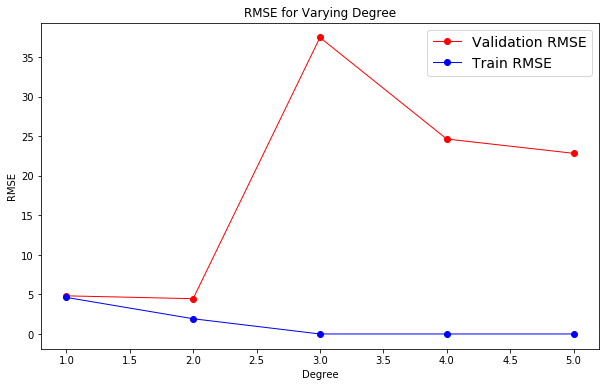


Optimal Degree:  2


In [9]:
# Partition the training data into train and validation subsets for this experiment
X_train_new, X_validation, y_train_new, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


degreeList = [1,2,3,4,5]

# Two lists to store train and validation MSE values for various models of varying complexity
mse_train_list, mse_validation_list = [], []

for degree in degreeList:

    # Create a pipeline object: first add polynomials, then standardize, finally create Linear Regression model 
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    # Train the model
    model.fit(X_train_new, y_train_new)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train_new)
    y_validation_predicted = model.predict(X_validation)
    
    
    # Compute MSE and add to the list
    mse_train_list.append(mean_squared_error(y_train_new, y_train_predicted))
    mse_validation_list.append(mean_squared_error(y_validation, y_validation_predicted))
   


# Plot RMSE values for varying polynomial degree
plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_validation_list), "ro-", alpha=1.0, linewidth=1.0, label="Validation RMSE")
plt.plot(degreeList, np.sqrt(mse_train_list), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()



# Find the value of optimal degree for the polynomial that gives smallest validation RMSE
rmse_validation = np.sqrt(mse_validation_list)
j = 0
min_rmse = rmse_validation[j]
optimal_degree = 1

for i in degreeList:
    if(rmse_validation[j] < min_rmse):
        min_rmse = rmse_validation[j]
        optimal_degree = i
    j +=1
    
print("\nOptimal Degree: ", optimal_degree)

## Computation of the Validation RMSE: Approach 2

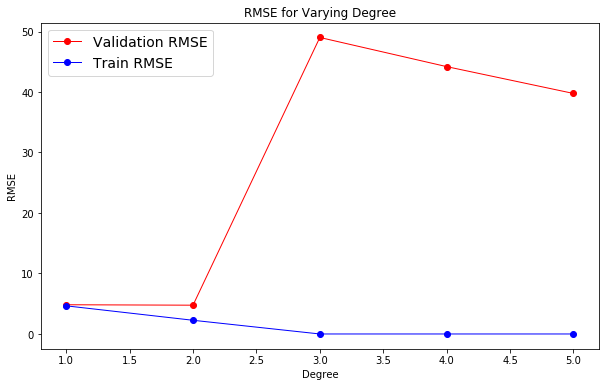

Optimal Degree:  2


In [10]:
degreeList = [1,2,3,4,5]

# Create two lists for storing MSE values (train & validation) for various polynomial degree values
mse_train_list, mse_validation_list = [], []

for degree in degreeList:

    # Create a OLS Linear Regression model using a pipeline object
    # In the pipeline, first add the polynomial features based on the given degree
    # Then, stadardize the data
    # Finally, create the Linear Regression model
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    # Train the model
    model.fit(X_train, y_train)

    # Make prediction using the training data 
    y_train_predicted = model.predict(X_train)

    # Compute the training MSE 
    mse_train = mean_squared_error(y_train, y_train_predicted)


    # Compute the validation MSE 
    #  - Use sklearn's metrics.cross_val_score() function that employs the cross-validation technique
    # Set its scoring argument with the value "neg_mean_squared_error" 
    # It returns a list of the negative MSE values
    # The length of the list depends on the value of the function's "cv" argument
    # Compute the mean of the negative MSE values
    # Then, multiply the mean with "-" to get the validation MSE score
    validation_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3)

    # Compute the mean of the multiple validation score values
    mse_validation = -validation_scores.mean()

    
    mse_train_list.append(mse_train)
    mse_validation_list.append(mse_validation)
   

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_validation_list), "ro-", alpha=1.0, linewidth=1.0, label="Validation RMSE")
plt.plot(degreeList, np.sqrt(mse_train_list), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")  

plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()


# Find the value the polynomial degree that gives the smallest validation RMSE
j = 0
min_validation_mse = mse_validation_list[j]
optimal_degree = 1

for i in degreeList:
    if(mse_validation_list[j] < min_validation_mse):
        min_validation_mse = mse_validation_list[j]
        optimal_degree = i
    j +=1
    
print("Optimal Degree: ", optimal_degree)

# Standardize the Features

In [11]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Train a Polynomial Linear Regression Model using the Optimal Degree

We use sklearn's **OLS Linear Regression** model to implement the Polynomial Linear Regression solution. We train the OLS LinearRegression() object with the augmented set of features.

In [12]:
# Polynomial Regression

# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree


# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])



# Create a linear regression object
lin_reg_poly = LinearRegression()

# Train the model
lin_reg_poly.fit(X_train_poly, y_train)


print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_poly_predicted = lin_reg_poly.predict(X_train_poly)


print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_poly_predicted))


# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_poly_predicted))

No. of Original Features:  13
No. of Augmented Features:  104

----------------------------- Model Evaluation -----------------------------

Mean squared error: 5.13
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.94


## Evaluate the Model Using Test Data

We will use the optimal degree for the polynomial to evaluate the model.

In [13]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree


# Add polynomial (without bias) with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)


print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_test_poly_predicted = lin_reg_poly.predict(X_test_poly)


print("\nMean squared error: %.2f"
      % mean_squared_error(y_test, y_test_poly_predicted))


# Explained variance score: 1 is perfect prediction
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' % r2_score(y_test, y_test_poly_predicted))


----------------------------- Model Evaluation -----------------------------

Mean squared error: 14.24
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.81


## MLE Technique 2: Using learning curve determine the optimal degree (model complexity) that produces best generalization


Another MLE technique to determine a polynomial model's complexity (whether it's overfitting or underfitting) is to look at the learning curve. 

A learning curve is a plot of the model’s performance on the training set and the validation set as a function of the training set size. To generate the plots for a given degree of polynomial, simply train the model several times on different sized subsets of the training set. 

Scikit-Learn provides a function for plotting learning curve.

## Learning Curve: Scikit-Learn


URL: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

The sklearn learning_curve function determines cross-validated training and validation scores for different training set sizes.

A cross-validation generator splits the whole dataset k times in training and validation data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the validation set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

#### Parameters of the learning_curve function:

- estimator : object type that implements the “fit” and “predict” methods. An object of that type which is cloned for each validation.
- X : array-like, shape (n_samples, n_features)
- y : array-like, shape (n_samples) or (n_samples, n_features)

- train_sizes : array-like, shape (n_ticks,), dtype float or int
Relative or absolute numbers of training examples that will be used to generate the learning curve. If the dtype is float, it is regarded as a fraction of the maximum size of the training set (that is determined by the selected validation method), i.e. it has to be within (0, 1]. Otherwise it is interpreted as absolute sizes of the training sets. Note that for classification the number of samples usually have to be big enough to contain at least one sample from each class. (default: np.linspace(0.1, 1.0, 5))

- cv : int, cross-validation generator or an iterable, optional
Determines the cross-validation splitting strategy. 
Possible inputs for cv are:
- - None, to use the default 3-fold cross validation
- - integer, to specify the number of folds in a (Stratified) KFold

- scoring : string, callable or None, optional, default: None
A string (see model evaluation documentation) or a scorer callable object/function with signature scorer(estimator, X, y).

- n_jobs : int or None, optional (default=None)
Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

## Analyze the Model Complexity Using Learning Curve

Our goal is to understand the phenomena of overfitting and underfitting by investigating various models.

We will generate two learning curves for a simple model and a complex model, respectively:
- Linear Model
- 4th Degree Polynomial Model

## Linear Model

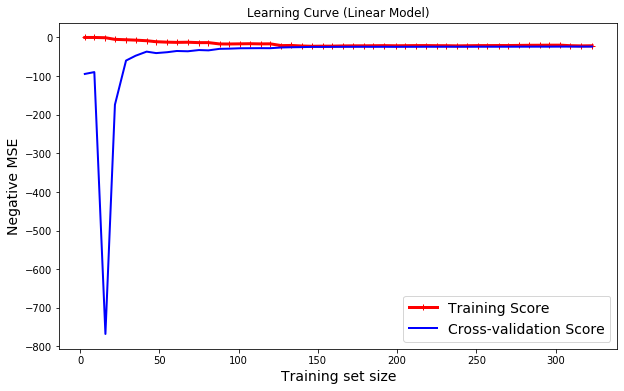

In [14]:
# Create CV training and validation scores for various training set sizes
train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train, y_train, cv=5, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50),
                                                        n_jobs=-1)
                                                
                                                                                                                                                                                                                 
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve (Linear Model)")
plt.show()

## Linear Model: Observation From the Learning Curve

First, let’s look at the performance on the training data: when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up (goes down for negative mse) until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse. 

Then, look at the performance of the model on the validation data. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.

These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high (large negative mse).


### High Bias:
A high-bias model is most likely to underfit the training data. The generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually non-linear. 


## How do we reduce high-bias (resolve underfitting)?
If the model is underfitting the training data, adding more training examples will not help. We need to use a more complex model or come up with better features.

## High-Degree (4th Degree) Polynomial Model

No. of Original Features:  13
No. of Augmented Features:  2379


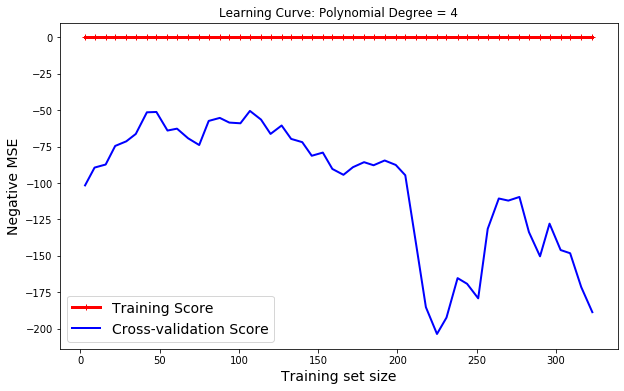

In [15]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = 4


# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])


scaler = StandardScaler().fit(X_train_poly)
X_train_poly_standardized = scaler.transform(X_train_poly)



train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train_poly_standardized, y_train, cv=5, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
                                                                                                                                                                                                       
                                                        
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve: Polynomial Degree = %d" % poly_degree)
plt.show()
                                     

## High-Degree (4th Degree) Polynomial Model: Observation From the Learning Curve

The error on the training data is zero, but on the validation its increasing.

There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. 


### High Variance:
A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data. The model is excessively sensitive to small variations in the training data. 


## How do we reduce high-variance (resolve overfitting)?
One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

When data is scare, overfitting (high variance) can be tamed by applying the Bayesian Learning aproach. In Bayesian Learning, we regularize (penalize) the model parameters.

In the next notebook we will see how to use Bayesian Learning for Linear Regression.

## RMSE vs Varying Degree

We plot multiple learning curves by varying the degree.

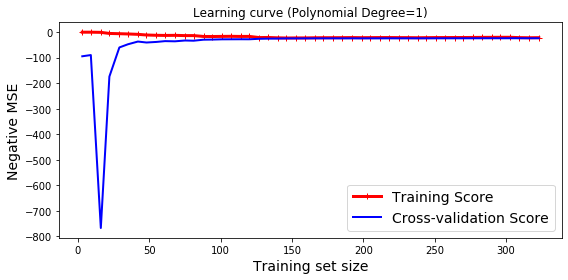

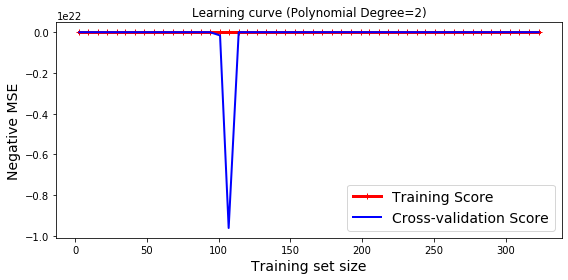

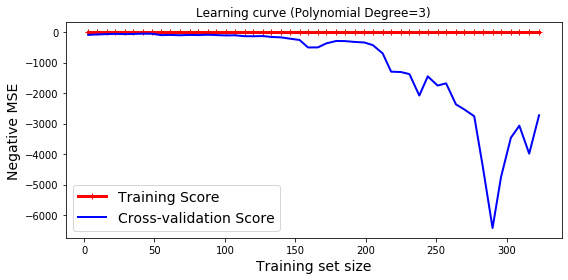

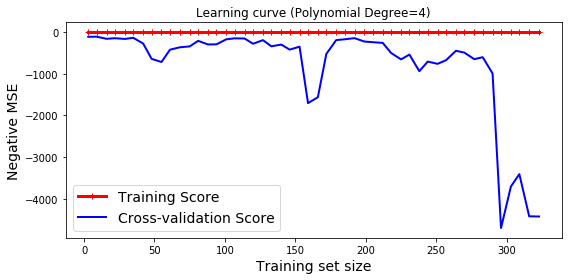

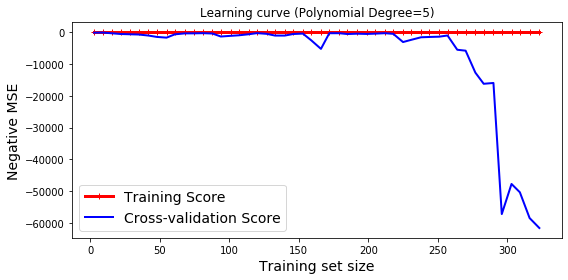

In [16]:
warnings.filterwarnings('ignore')

for d in [1, 2, 3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree=d), LinearRegression())

    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, 
                                                                  scoring='neg_mean_squared_error', 
                                                                  train_sizes=np.linspace(0.01, 1.0, 50))

   
    # Create means and standard deviations of training & validation set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

   
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)


    # Plot the mean train error and validation error across folds
    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
    plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
    plt.legend(loc="best", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("Negative MSE", fontsize=14) 
    plt.title('Learning curve (Polynomial Degree=%i)' % d)
    plt.tight_layout()


plt.show()


# <font color=blue> Final Note:  Polynomial Regression </font>


We observe that the 2nd degree polynomial model improves the test data performance significantly better than other models.

However, in general, increasing a model’s complexity (higher-degree polynomial) will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. Thus, we need to do bias-variance tradeoff.


Next we will see the performance of the **regularized** high-degree polynomial model (Bayesian approach) to obtain an optimal tradeoff.